# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from utils import *

from tqdm import tqdm

# Setup

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def sigmoid_k(u, k=1):
    return 1 / (1 + torch.exp(-k * u))

def standardized_sigmoid(u, k=1):
    return 1 - torch.log( 1 + torch.exp(-k*u) )/np.log(2)

def indicator_positive(u,k=1):
    return torch.where(u >= 0, torch.tensor(1, device=device), torch.tensor(0, device=device))

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        return x

In [8]:
n_samples, input_dim, hidden_dim, output_dim = 1000, 4, 64, 1
lambda_pen = 1

## Linear
#w_star = np.zeros(input_dim)
#w_star[:math.ceil(input_dim/2)] = np.ones(math.ceil(input_dim/2))
#f_star = lambda x: x@w_star

## MLP
W_hidden = np.random.normal(size=(input_dim,hidden_dim))
W_ouput = np.random.normal(size=(hidden_dim, output_dim))
ReLU_array = lambda x: x * (x > 0)
f_star = lambda x: (ReLU_array(x@W_hidden)@W_ouput).flatten()

data = generate_cox_model_multivariate(n_samples, f_star, input_dim, lambda_tuning=lambda_pen)
X = data['X']
delta = data['delta']
T_tilde = data['T_tilde']
X_torch = torch.tensor(X, dtype=torch.float32, device=device)
delta_torch = torch.tensor(delta, dtype=torch.float32, device=device)
T_tilde_torch = torch.tensor(T_tilde, dtype=torch.float32, device=device)

In [9]:
censorship_level = (1-data['delta']).mean()*100
print(f'Data are censored at {censorship_level}%')

Data are censored at 71.8%


# Optimization

In [10]:
model_SHCIM = SHCIM(X_torch, delta_torch, T_tilde_torch, device)
model_SHCIM.fit()

number_of_epochs = 500
number_of_iteration_mc = 500
smoothing_func = standardized_sigmoid

C_values = []

model = MLP(input_dim, hidden_dim, output_dim)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, maximize=True)
    
for epoch in tqdm(range(number_of_epochs)):
    optimizer.zero_grad()
    loss = model_SHCIM.predict(smoothing_func, model)
    loss.backward()
    optimizer.step()

    f = lambda x: model(torch.tensor(x, dtype=torch.float32, device=device)).cpu().detach().clone().numpy()
    C_values.append( monte_carlo_cox_concordance_index(f, number_of_iteration_mc, input_dim, f_star) )

100%|██████████| 500/500 [00:35<00:00, 14.01it/s]


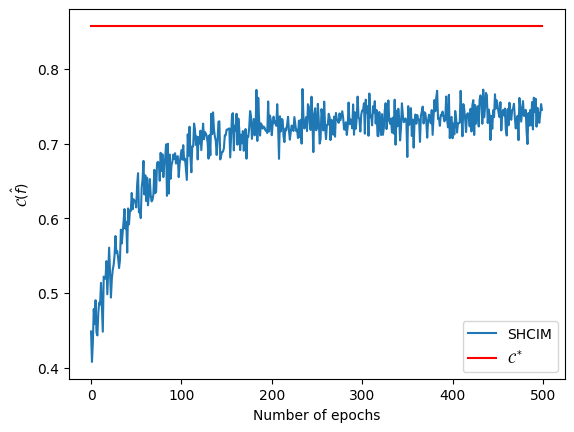

In [11]:
C_star = maximum_of_C_index_cox_model(f_star, input_dim, 1000)
plt.figure()
plt.plot(C_values, label='SHCIM')
plt.plot([C_star]*len(C_values), c='r',label='$\mathcal{C}^*$')
plt.xlabel('Number of epochs')
plt.ylabel('$\mathcal{C}(\hat{f})$')
plt.legend()
plt.show()